# GA & GP optimization of NN

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import genetic_algorithm as ga
from nn_ga import GenAlgNN
from nn_gp import GenProgNN

## Generate and load data

In [2]:
def print_spiral():
    from math import pi, sin, cos
    theta = 0.5 * pi
    while theta < 3.5 * pi:
        r = theta * 1.5 / pi
        x = r * sin(theta)
        y = r * cos(theta)
        print(f'{x:.6f},{y:.6f},1')
        print(f'{-x:.6f},{-y:.6f},-1')
        theta += 0.125 / r

In [3]:
print_spiral()

0.750000,0.000000,1
-0.750000,-0.000000,-1
0.818082,-0.137624,1
-0.818082,0.137624,-1
0.856506,-0.281316,1
-0.856506,0.281316,-1
0.868843,-0.426148,1
-0.868843,0.426148,-1
0.858125,-0.568578,1
-0.858125,0.568578,-1
0.827030,-0.705980,1
-0.827030,0.705980,-1
0.777977,-0.836372,1
-0.777977,0.836372,-1
0.713175,-0.958250,1
-0.713175,0.958250,-1
0.634662,-1.070481,1
-0.634662,1.070481,-1
0.544318,-1.172224,1
-0.544318,1.172224,-1
0.443891,-1.262874,1
-0.443891,1.262874,-1
0.334999,-1.342021,1
-0.334999,1.342021,-1
0.219148,-1.409413,1
-0.219148,1.409413,-1
0.097735,-1.464936,1
-0.097735,1.464936,-1
-0.027944,-1.508584,1
0.027944,1.508584,-1
-0.156687,-1.540451,1
0.156687,1.540451,-1
-0.287380,-1.560706,1
0.287380,1.560706,-1
-0.418995,-1.569591,1
0.418995,1.569591,-1
-0.550583,-1.567401,1
0.550583,1.567401,-1
-0.681270,-1.554482,1
0.681270,1.554482,-1
-0.810254,-1.531220,1
0.810254,1.531220,-1
-0.936802,-1.498033,1
0.936802,1.498033,-1
-1.060243,-1.455366,1
1.060243,1.455366,-1
-1.179970,-

In [4]:
spiral = pd.read_csv('../two_spirals.csv', names=['x', 'y', 'class'])

In [5]:
X_valid = spiral.copy()
y_valid = X_valid.pop('class')

X_train = spiral.sample(frac=0.5)
y_train = X_train.pop('class')

In [6]:
X_valid

,x,y
0,0.750000,0.000000
1,-0.750000,-0.000000
2,0.818082,-0.137624
3,-0.818082,0.137624
4,0.856506,-0.281316
...,...,...
447,5.217540,0.275522
448,-5.234056,-0.150959
449,5.234056,0.150959
450,-5.247566,-0.026036


In [7]:
y_valid

0      1
1     -1
2      1
3     -1
4      1
      ..
447   -1
448    1
449   -1
450    1
451   -1
Name: class, Length: 452, dtype: int64

In [8]:
X_train

,x,y
57,1.705471,1.027534
38,-0.681270,-1.554482
395,3.779800,3.147160
215,-3.606672,-0.650289
200,3.238067,1.452030
...,...,...
389,3.501561,3.401769
438,-5.121496,-0.768717
169,-1.738398,-2.767065
251,-3.614199,1.587942


In [9]:
y_train

57    -1
38     1
395   -1
215   -1
200    1
      ..
389   -1
438    1
169   -1
251   -1
132    1
Name: class, Length: 226, dtype: int64

## Visualisation utilities

In [10]:
def visualize_model(model):
    global X_train, y_train
    points = np.zeros([120, 120, 2])
    for y in range(120):
        for x in range(120):
            points[y, x, 0] = (x - 60) / 10.0
            points[y, x, 1] = (y - 60) / 10.0
    plt.imshow(model.predict(points.reshape([-1, 2])).reshape([120, 120]), cmap='cividis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.axis('off')
    points = X_train.where(y_train > 0) * 10 + 60
    plt.scatter(points['x'], points['y'], c='red')
    points = X_train.where(y_train < 0) * 10 + 60
    plt.scatter(points['x'], points['y'], c='limegreen')
    plt.show()

In [11]:
def print_population(fitnesses, population):
    arr = [(1.0 / f - 1.0, i) for f, i in zip(fitnesses, population)]
    arr.sort(key=lambda t: t[0])
    for m, i in arr:
        print(f'mse={m:.4f} {i}')
    return arr

## Test NN

In [12]:
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.03))
model.fit(np.array(X_train), np.array(y_train), epochs=2000, batch_size=8, verbose=0)
keras.losses.MeanSquaredError()(y_valid, model.predict(X_valid)).numpy()

1.948672

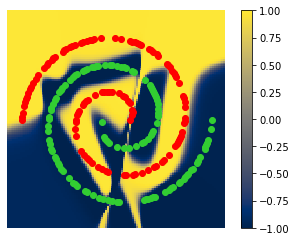

In [13]:
visualize_model(model)

## Genetic Algorithm

In [14]:
problem_ga = GenAlgNN((np.array(X_train), np.array(y_train)), (np.array(X_valid), np.array(y_valid)))
ga_optimizer = ga.GAOptimizer(problem_ga)

In [15]:
ga_optimizer.start(6)
for i in range(4):
    old_population = ga_optimizer.population
    gen_ga, old_fitnesses = ga_optimizer.next_generation()
    print_population(old_fitnesses, old_population)
    print('=== New generation ===', i)

mse=1.3234 [2, 3, 4, 1]
mse=1.3347 [2, 4, 5, 2]
mse=1.8090 [1, 3, 8, 7]
mse=1.8515 [0, 3, 5, 8]
mse=1.9077 [7, 3, 5, 5]
mse=1.9136 [7, 0, 5, 8]
=== New generation === 0
mse=1.4098 [2, 3, 5, 2]
mse=1.4793 [2, 3, 4, 1]
mse=1.5827 [0, 3, 5, 8]
mse=1.7986 [1, 3, 8, 7]
mse=1.8452 [7, 4, 5, 5]
mse=1.8915 [7, 3, 5, 5]
=== New generation === 1
mse=1.4058 [1, 3, 8, 5]
mse=1.7511 [1, 3, 5, 5]
mse=1.8129 [7, 4, 8, 7]
mse=1.8796 [1, 4, 8, 7]
mse=1.9098 [7, 3, 5, 5]
mse=1.9191 [7, 3, 7, 7]
=== New generation === 2
mse=1.6031 [1, 3, 8, 5]
mse=1.6192 [7, 4, 2, 7]
mse=1.7144 [1, 3, 8, 7]
mse=1.7505 [1, 4, 8, 7]
mse=1.7897 [1, 4, 8, 6]
mse=1.7951 [1, 4, 8, 7]
=== New generation === 3


In [16]:
fitnesses_ga = [problem_ga.fitness(i) for i in gen_ga]
mse_ga = print_population(fitnesses_ga, gen_ga)

mse=1.6636 [1, 3, 8, 7]
mse=1.7116 [1, 4, 8, 7]
mse=1.7558 [1, 4, 8, 7]
mse=1.7713 [1, 4, 8, 7]
mse=1.8234 [1, 3, 8, 5]
mse=1.9105 [8, 4, 8, 7]


In [17]:
problem_ga.epochs = 4000
model_ga = problem_ga.train_nn(mse_ga[0][1])
keras.losses.MeanSquaredError()(y_valid, model_ga.predict(X_valid)).numpy()

1.7188671

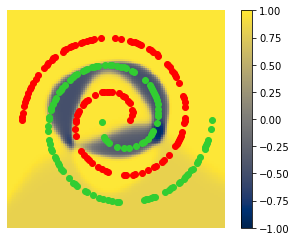

In [18]:
visualize_model(model_ga)

In [25]:
mse_ga[0][1]

[1, 3, 8, 7]

## Genetic Programming

In [19]:
problem_gp = GenProgNN((np.array(X_train), np.array(y_train)), (np.array(X_valid), np.array(y_valid)))
gp_optimizer = ga.GAOptimizer(problem_gp)

In [20]:
gp_optimizer.start(6)
for i in range(6):
    old_population = gp_optimizer.population
    gen_gp, old_fitnesses = gp_optimizer.next_generation()
    print_population(old_fitnesses, old_population)
    print('=== New generation ===', i)

mse=1.1070 Layer(1)
mse=1.1617 Layer(1)
mse=1.1753 Layer(1)
mse=1.3059 Layer(1)
mse=1.6906 Layer(1)
mse=1.8204 Layer(1)
=== New generation === 0
mse=1.0708 Layer(1)
mse=1.1164 Layer(1)
mse=1.1931 Layer(1)
mse=1.2121 Layer(1)
mse=1.2169 Layer(1)
mse=1.2830 Layer(1)
=== New generation === 1
mse=1.0171 Layer(1)
mse=1.1434 Layer(1)
mse=1.1815 Layer(1)
mse=1.5644 Layer(1)
mse=1.5678 Layer(1)
mse=1.6184 Layer(1)
=== New generation === 2
mse=1.0015 Layer(1)
mse=1.1682 Layer(1)
mse=1.4228 Layer(1)
mse=1.4319 Layer(1)
mse=1.8142 Layer(1)
mse=1.9940 Layer(1)
=== New generation === 3
mse=1.0060 Layer(1)
mse=1.0971 Layer(1)
mse=1.1782 Layer(1)
mse=1.2574 Layer(1)
mse=1.9853 Layer(1)
mse=1.9923 Layer(1)
=== New generation === 4
mse=1.1735 Layer(1)
mse=1.1750 Layer(1)
mse=1.9807 Layer(1)
mse=1.9815 Layer(1)
mse=1.9908 Layer(1)
mse=1.9919 Layer(1)
=== New generation === 5


In [21]:
fitnesses_gp = [problem_gp.fitness(i) for i in gen_gp]
mse_gp = print_population(fitnesses_gp, gen_gp)

mse=1.2348 Layer(1)
mse=1.6378 Layer(1)
mse=1.9822 Layer(1)
mse=1.9914 Layer(1)
mse=1.9952 Layer(1)
mse=1.9959 Layer(1)


In [22]:
problem_gp.epochs = 4000
model_gp = problem_gp.train_nn(mse_gp[0][1])
keras.losses.MeanSquaredError()(y_valid, model.predict(X_valid)).numpy()

1.948672

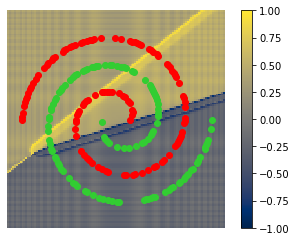

In [23]:
visualize_model(model_gp)

In [24]:
for item in mse_gp:
    print('digraph {')
    print(item[1].to_dot())
    print('}')
    print()

digraph {
ID139766224103024 [label="Layer(1)"];
ID139766226778048 -> ID139766224103024;
ID139766226778048 [label="Function(square)"];
ID139766227449984 -> ID139766226778048;
ID139766227449984 [label="Concatenation"];
ID139766225630976 -> ID139766227449984;
ID139766225630976 [label="Function(sin)"];
ID139766225632368 -> ID139766225630976;
ID139766225632368 [label="Input"];
ID139766225652992 -> ID139766227449984;
ID139766225652992 [label="Function(sin)"];
ID139766225580624 -> ID139766225652992;
ID139766225580624 [label="Concatenation"];
ID139766225580768 -> ID139766225580624;
ID139766225580768 [label="Function(square)"];
ID139766225580960 -> ID139766225580768;
ID139766225580960 [label="Input"];
ID139766225581152 -> ID139766225580624;
ID139766225581152 [label="Layer(8)"];
ID139766225581344 -> ID139766225581152;
ID139766225581344 [label="Layer(2)"];
ID139766225581536 -> ID139766225581344;
ID139766225581536 [label="Layer(8)"];
ID139766225581728 -> ID139766225581536;
ID139766225581728 [label